## TODO:
- implement alternating minimization scheme: gctr_v, gctr_w
- implement search for multiple pairs

In [1]:
import numpy as np
import scipy
import scipy.optimize
import scipy.io as sio
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
from gca import gc_block_covariance, gca_obj, gca_obj_v, gca_obj_w, unit_norm

## Bring in synthetic VAR data

In [2]:
x = scipy.io.loadmat('../Xtest3.mat')['x']
stats = scipy.io.loadmat('../Xtest3.mat')['stats']
xr = np.flipud(x)

A = stats['A'][0][0]
D=4
L=3

In [3]:
s1=stats['S'][0][0][0,:]
s2=stats['S'][0][0][1,:]
s3=stats['S'][0][0][2,:]

In [4]:
blkR1, Rtilde = gc_block_covariance(x,L) # forward time
blkR1r, Rtilder = gc_block_covariance(xr,L) # reverse time

## Evaluate GCA objective with ground-truth spatial filters
s1 is the driving signal (recovered by wtrue)
s2 is the driven signal (recovered by vtrue)

In [5]:
pinvA=np.linalg.pinv(A.T)
wtrue=pinvA[:,0]
vtrue=pinvA[:,1]
x_gt=np.concatenate( ( vtrue , wtrue ) ,axis=0 )

In [6]:
gca_obj(x_gt, blkR1, Rtilde, blkR1r, Rtilder)

array([[-0.12002387]])

## Prepare non-linear unit-norm constraint for GCA optimization

In [7]:
results = {'data': x} # initialize results dictionary

n_pairs = 2

# initialize v and w
v = 0.001 * np.random.randn(D,)
w = 0.001 * np.random.randn(D,)

for p in range(1,n_pairs+1):

    for iter in range(10):

            print(iter)

            optres_v = minimize(gca_obj_v, 0.01*np.random.randn(D,), args=( (w, blkR1, Rtilde, blkR1r, Rtilder) ) , method='trust-constr', constraints=[scipy.optimize.NonlinearConstraint(unit_norm, 1, 1)])

            v = optres_v.x

            optres_w = minimize(gca_obj_w, 0.01*np.random.randn(D,), args=( (v, blkR1, Rtilde, blkR1r, Rtilder) ) , method='trust-constr', constraints=[scipy.optimize.NonlinearConstraint(unit_norm, 1, 1)])

            w = optres_w.x

    # compute the driven signal
    y_hat = x@w

    # form a convolution matrix from y_hat
    convmat = scipy.linalg.convolution_matrix(y_hat, L, mode='full')[0:-L+1,:]
    # add a column of ones to convmat
    convmat = np.concatenate((convmat, np.ones((convmat.shape[0],1))), axis=1)

    # regress out y_hat from x
    x_ = x - convmat@np.linalg.pinv(convmat)@x

    # replace x with x_
    #x = x_
    xr_ = np.flipud(x_)
    blkR1, Rtilde = gc_block_covariance(x_,L) # forward time
    blkR1r, Rtilder = gc_block_covariance(xr_,L) # reverse time

    results[p] = {'v': v, 'w': w, 'optres_v': optres_v, 'optres_w': optres_w}


0


/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


1
2
3
4
5
6
7
8
9
0


/Users/jacekdmochowski/PROJECTS/gca/code/python/notebooks/gca.py:162: RuntimeWarning: invalid value encountered in log
  Gr = np.log(phi_f(w,v,blkR1r,Rtilder,L)) - np.log(phi_r(w,blkR1r,Rtilder,L))


ValueError: array must not contain infs or NaNs

In [106]:
results

{'data': array([[-0.55075763, -0.20559031, -0.19472622, -0.61662723],
        [-0.96995619, -0.93477038, -0.53611507, -0.63014012],
        [-1.74998833, -0.79236436, -0.47930343, -1.27869637],
        ...,
        [ 2.88917059,  2.53312401,  1.80363336,  2.95124364],
        [ 1.18373222,  1.45211493,  0.90869353,  0.97039433],
        [-0.46229862, -0.3716031 , -0.18537869, -0.22089459]]),
 0: {'v': array([-0.20217168,  0.46940731, -0.80952248,  0.2888888 ]),
  'w': array([-0.20767754,  0.20129912,  0.55199644, -0.78207968]),
  'optres_v':           message: `xtol` termination condition is satisfied.
            success: True
             status: 2
                fun: -0.11388521505654997
                  x: [-2.022e-01  4.694e-01 -8.095e-01  2.889e-01]
                nit: 514
               nfev: 4590
               njev: 918
               nhev: 0
           cg_niter: 1172
       cg_stop_cond: 4
               grad: [-2.392e-06  7.130e-06 -5.804e-06  4.053e-06]
    lagrangian_gr

In [25]:
v, w
#gca_obj(np.concatenate((v,w), axis=0),blkR1,Rtilde,blkR1r,Rtilder)

(array([-0.20468557,  0.51469762, -0.80360192,  0.21774786]),
 array([-0.17801747,  0.47607897, -0.82163401,  0.25802353]))

In [108]:
results[0]['w'].T@A, results[0]['v'].T@A, results[1]['w'].T@A, results[1]['v'].T@A

(array([ 0.09545921, -0.49578542, -0.04865914]),
 array([ 3.97408113e-05,  2.29933480e-03, -1.55983493e-02]),
 array([-0.10081235,  0.52502588,  0.0514015 ]),
 array([-3.87835627e-05, -2.28743803e-03,  1.55841024e-02]))

## Run the GCA optimizer

In [10]:
#optres = minimize(gca_obj, 0.01*np.random.randn(2*D,), args=( (blkR1,Rtilde,blkR1r,Rtilder) ) , method='trust-constr', constraints=[scipy.optimize.NonlinearConstraint(nlcv, 1, 1),scipy.optimize.NonlinearConstraint(nlcw, 1, 1)])

/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [11]:
#gca_obj(optres.x,blkR1,Rtilde,blkR1r,Rtilder)

array([[-0.11388443]])

In [12]:
#vstar=optres.x[0:D]
#wstar=optres.x[D:2*D+1]

<StemContainer object of 3 artists>

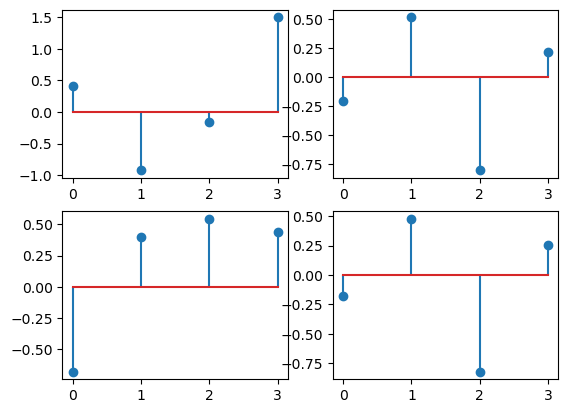

In [30]:
fig, ax = plt.subplots(2,2)
ax[0,0].stem(vtrue)
ax[0,1].stem(v)
ax[1,0].stem(wtrue)
ax[1,1].stem(w)

In [33]:
w.T@A, wtrue.T@A

(array([-0.02084364, -0.00018972, -0.00039625]),
 array([1.00000000e+00, 2.45775074e-16, 2.26972804e-16]))

In [34]:
v.T@A, vtrue.T@A

(array([ 0.00127161, -0.03189154,  0.00136117]),
 array([ 1.18650568e-16,  1.00000000e+00, -1.48052910e-16]))

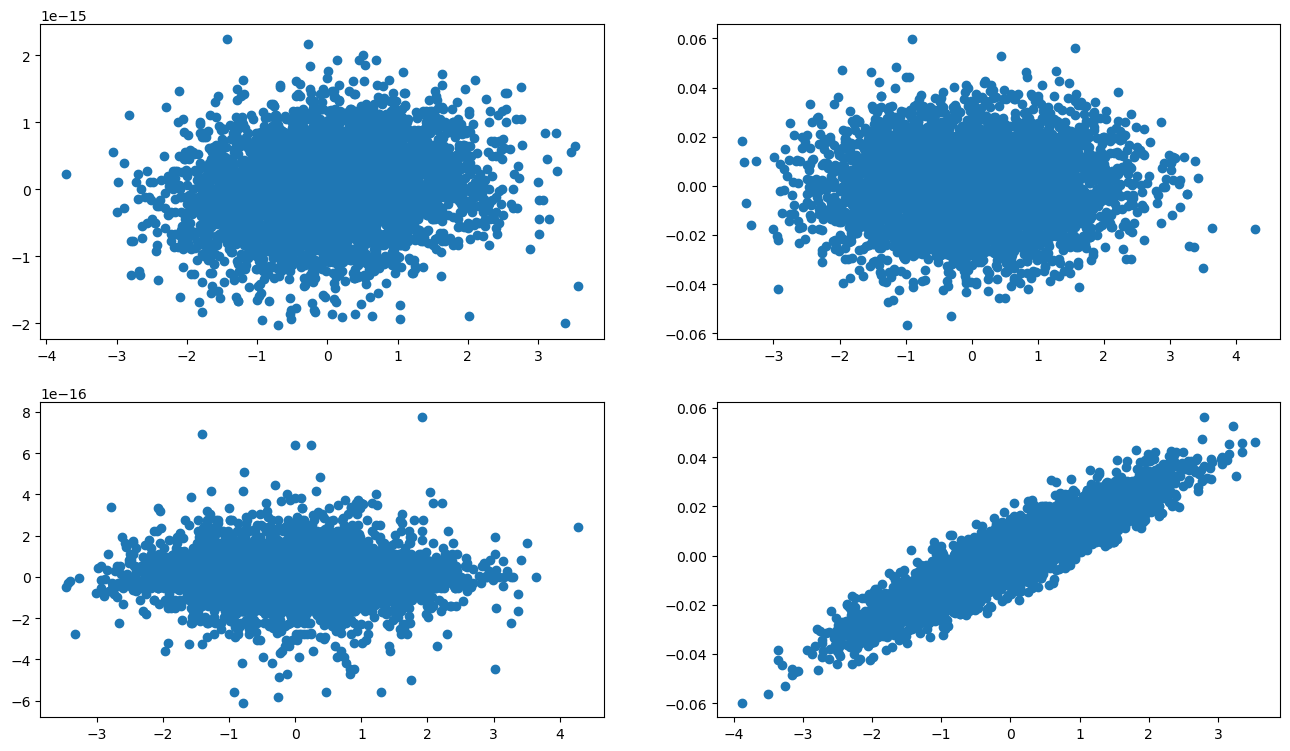

In [109]:
y_hat_1 = x@results[0]['w']
z_hat_1 = x@results[0]['v']
y_hat_2 = x@results[1]['w']
z_hat_2 = x@results[1]['v']
fig, ax = plt.subplots(2,2,figsize=(16,9))
ax[0,0].scatter(s1,y_hat_1)
ax[0,1].scatter(s2,z_hat_1)
ax[1,0].scatter(s2,y_hat_2)
ax[1,1].scatter(s3,z_hat_2)

In [70]:
convmat = scipy.linalg.convolution_matrix(y_hat, L, mode='full')[0:-L+1,:]
# add a column of ones to convmat
convmat = np.concatenate((convmat, np.ones((convmat.shape[0],1))), axis=1)
convmat.shape

(5000, 4)

In [73]:
x_ = x - convmat@np.linalg.pinv(convmat)@x

In [76]:
x_.shape, y_hat.shape

((5000, 4), (5000,))

In [82]:
np.corrcoef( np.squeeze(x_[:,0]), y_hat), np.corrcoef( np.squeeze(x[:,0]), y_hat)

(array([[1.00000000e+00, 1.75269571e-16],
        [1.75269571e-16, 1.00000000e+00]]),
 array([[ 1.        , -0.06575996],
        [-0.06575996,  1.        ]]))

In [83]:
np.roll([1,2,3],1)

array([3, 1, 2])

In [96]:
np.corrcoef( np.squeeze(x_[:,0]), np.roll(y_hat,2)), np.corrcoef( np.squeeze(x[:,0]), np.roll(y_hat,2))

(array([[1.00000000e+00, 5.96377947e-05],
        [5.96377947e-05, 1.00000000e+00]]),
 array([[1.        , 0.00634173],
        [0.00634173, 1.        ]]))

In [94]:
convmat[0:5,:], y_hat[0:5], x.shape, y_hat.shape

(array([[ 0.00105661,  0.        ,  0.        ,  1.        ],
        [ 0.00554403,  0.00105661,  0.        ,  1.        ],
        [-0.00182125,  0.00554403,  0.00105661,  1.        ],
        [ 0.01118145, -0.00182125,  0.00554403,  1.        ],
        [ 0.01582905,  0.01118145, -0.00182125,  1.        ]]),
 array([ 0.00105661,  0.00554403, -0.00182125,  0.01118145,  0.01582905]),
 (5000, 4),
 (5000,))

Code for generating VAR data is below

In [13]:
#B = np.array([[0.9, 0], [-0.2, 0.8]])

#D=x.shape[0] # of sensors
#M=2 # of sources
#L=1 # max lag of AR model
#T=50000 # of time samples
#noisepwr=1
#A = np.random.rand(D,M) # mixing matrix
#sensornoisepwr=0.1

# latent sources
#s = np.zeros(shape=(M,T))
#s[:,0:L] = np.random.randn(M,L)
#sinn = noisepwr*np.random.randn(M,T)

In [14]:
#for t in range(L,T):
#    s[:,t] = B@s[:,t-1] + sinn[:,t]
#x = A@s + sensornoisepwr*np.random.randn(D,T)